In [8]:
%matplotlib widget

import math
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import wandb

from notebook_utils import *

DF_CACHE = {}

def key_to_nice_name(key):
    return {
        "ENTROPY": "Entropy",
        "CERTAINTY": "R-Certainty",
        "UNCERTAINTY": "Active-R-Uncertainty",
        "OFFLINE": "Offline-Random",
        "RANDOM": "Random",
        "HIGH_ENTROPY_AND_CERTAINTY": "Entropy + R-Certainty",
    }[key]


In [9]:
WIN_RATE = "post_training_m/eval_T0.25/win_rate"
ACQ = "acquire_pairs_function"
tag = "xmas-sweep2"

all_dfs = []

for run in wandb.Api().runs("bbnn/wm-debug-imdb"):
    if tag in run.tags:
        print(run.name, run.state)
        cfg = json.loads(run.json_config)
        df = DF_CACHE.get(run.id)
        if df is None:        
            df = pd.DataFrame(run.scan_history())
            print(df.columns)
            if WIN_RATE in df.columns:
                print("Processing DF")
                cols = ["m", WIN_RATE]
                df = df[cols]
                df['m'] = df['m'].fillna(method="ffill")
                df = df[~df[WIN_RATE].isnull()]
                df["m"] = df["m"].astype(int)
                df["acq"] = cfg["exp5"]["value"][ACQ]
                df["seed"] = int(cfg["seed"]["value"])
                df["win_rate"] = df[WIN_RATE]
                if run.state == "finished":
                    DF_CACHE[run.id] = df    
        
        all_dfs.append(df)
        
df = pd.concat(all_dfs)
df = df[df.m <= 1024]

faithful-blaze-137 finished
Index(['stopper_loss_ma', 'stopper_target', 'epoch', '_runtime',
       'direct/loss/total', 'env/kl_mean',
       'post_training_m/eval_T0.25/kl_mean',
       'post_training_m/eval_T0.25/logprobs_dist', '_timestamp',
       'post_training_m/eval_T0.25/kl_dist', 'env/mean_logp_w',
       'post_training_m/eval_T0.25/ref_logprobs_mean', 'm', 'step',
       'env/mean_ref_logp_w', 'env/mean_logp_l', 'lr', 'env/mean_ref_logp_l',
       'post_training_m/eval_T0.25/logprobs_mean', '_step',
       'post_training_m/eval_T0.25/time',
       'post_training_m/eval_T0.25/vs_rows_vs_ref_model',
       'post_training_m/eval_T0.25/ref_logprobs_dist'],
      dtype='object')
lilac-fog-136 finished
Index(['stopper_target', 'post_training_m/eval_T0.25/logprobs_dist', '_step',
       'env/kl_mean', 'env/mean_logp_l', '_timestamp', 'env/mean_logp_w',
       'post_training_m/eval_T0.25/kl_mean', 'post_training_m/eval_T0.25/time',
       'post_training_m/eval_T0.25/ref_logprobs_dis

KeyboardInterrupt: 

In [5]:
df.head()

,stopper_loss_ma,stopper_target,epoch,_runtime,direct/loss/total,env/kl_mean,post_training_m/eval_T0.25/kl_mean,post_training_m/eval_T0.25/logprobs_dist,_timestamp,post_training_m/eval_T0.25/kl_dist,...,step,env/mean_ref_logp_w,env/mean_logp_l,lr,env/mean_ref_logp_l,post_training_m/eval_T0.25/logprobs_mean,_step,post_training_m/eval_T0.25/time,post_training_m/eval_T0.25/vs_rows_vs_ref_model,post_training_m/eval_T0.25/ref_logprobs_dist
0,NaN,0.0,0.0,7558.711430,0.726361,-1.038182,NaN,None,1.703830e+09,None,...,0.0,-2.119287,-2.153252,0.000001,-2.104404,NaN,0,NaN,None,None
1,0.726361,0.0,0.0,7561.810953,0.727345,-1.128513,NaN,None,1.703830e+09,None,...,1.0,-2.075022,-2.138550,0.000001,-2.087290,NaN,1,NaN,None,None
2,0.726459,0.0,1.0,7564.917392,0.660462,-1.141210,NaN,None,1.703830e+09,None,...,2.0,-2.105813,-2.116462,0.000001,-2.047105,NaN,2,NaN,None,None
3,0.719859,0.0,1.0,7568.062632,0.654043,-1.189884,NaN,None,1.703830e+09,None,...,3.0,-2.089644,-2.213114,0.000001,-2.140916,NaN,3,NaN,None,None
4,0.713278,0.0,2.0,7571.172695,0.635560,-1.279666,NaN,None,1.703830e+09,None,...,4.0,-2.122526,-2.236690,0.000001,-2.156216,NaN,4,NaN,None,None


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

df_filtered = df[df['acq'].isin(['CERTAINTY', 'ENTROPY', 'HIGH_ENTROPY_AND_CERTAINTY', 'RANDOM'])]

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_filtered, x="m", y=WIN_RATE, hue="acq", ci='sd')
sns.lineplot(data=df_filtered, x="m", y=WIN_RATE, hue="acq", legend=False)
plt.xlabel('Acquisition steps')
plt.ylabel('Win rate vs initial model')
plt.savefig('imdb_acq_winrate.png', dpi=300)
plt.show()

KeyError: 'acq'

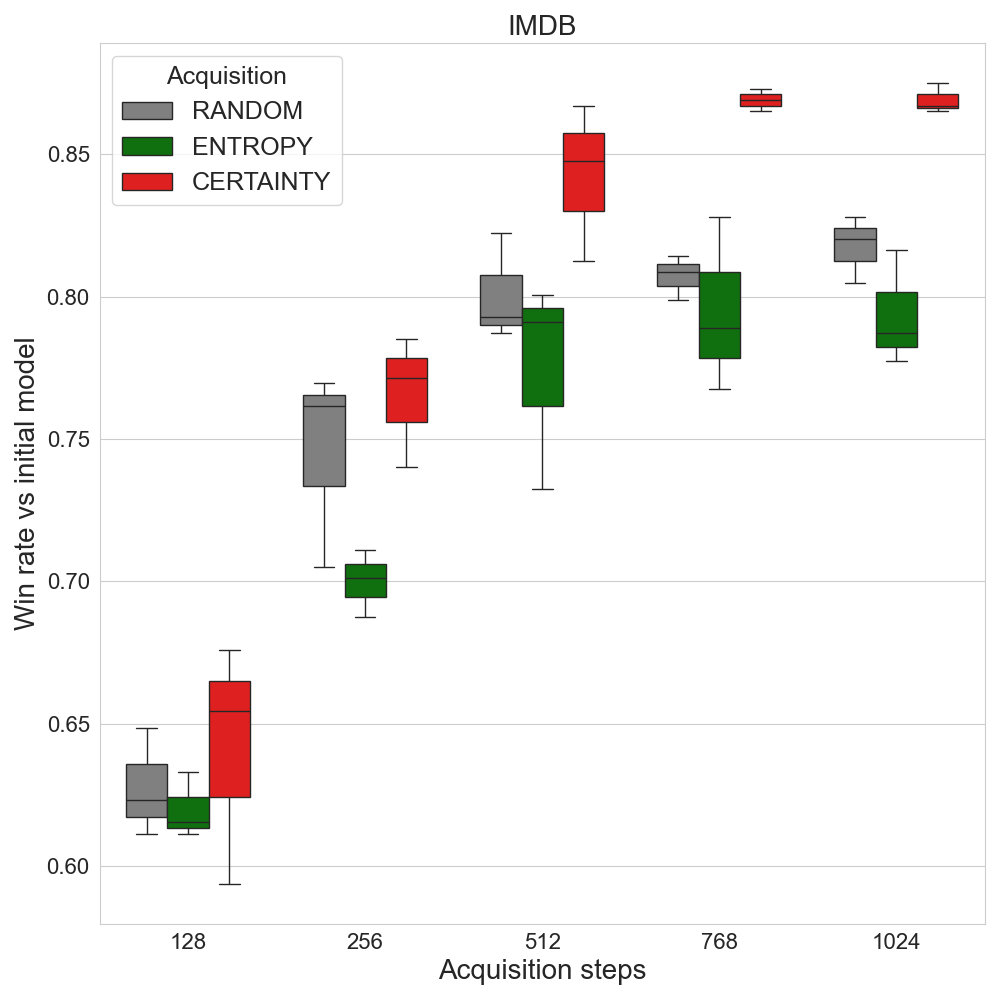

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

df_filtered = df[df['acq'].isin(['CERTAINTY', 'ENTROPY', 'RANDOM'])]


sns.set_style("whitegrid")  # Set plot style

palette = {'RANDOM': 'grey', 'ENTROPY': 'green', 'CERTAINTY': 'red'}
order = ['RANDOM', 'ENTROPY','CERTAINTY']

plt.figure(figsize=(10, 10))  # Set same width and height
sns.boxplot(data=df_filtered, x="m", y=WIN_RATE, hue="acq", width=0.7,
            palette=palette,
            hue_order=order,
            )  # Set width of boxplot


plt.xlabel('Acquisition steps', fontsize=20)
plt.ylabel('Win rate vs initial model', fontsize=20)
plt.xticks(fontsize=16)  # Increase fontsize for x-axis tick labels
plt.yticks(fontsize=16)  # Increase fontsize for y-axis tick labels

handles, labels = plt.gca().get_legend_handles_labels()
labels = [key_to_nice_name(label) for label in labels]
plt.legend(handles, labels, title='Acquisition', fontsize=18, title_fontsize=18)

plt.title('IMDB', fontsize=20)

plt.savefig('imdb_acq_winrate.png', dpi=300)
plt.tight_layout()  # Adjust layout to fit plot properly
plt.show()

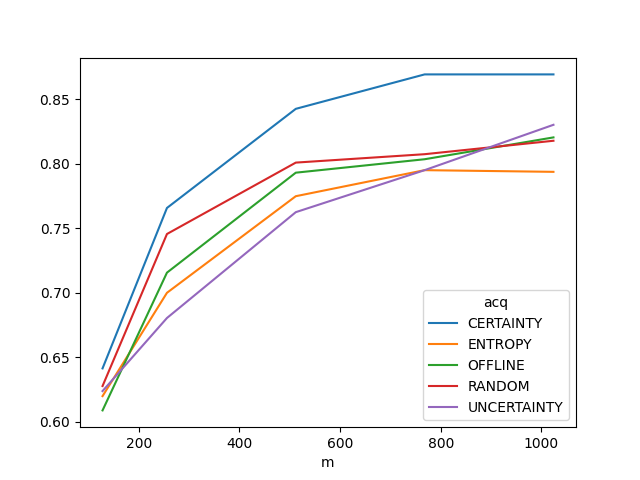

In [14]:
df.groupby(["m", "acq"])[WIN_RATE].mean().unstack().plot();

In [15]:
df_agg = df.groupby(["m", "acq"])[WIN_RATE].agg([np.mean, np.std, len]).reset_index()
df_agg['stderr'] = df_agg['std'] / df_agg['len']**0.5

In [16]:
df_agg

,m,acq,mean,std,len,stderr
0,128,CERTAINTY,0.641276,0.042537,3,0.024559
1,128,ENTROPY,0.619792,0.011444,3,0.006607
2,128,OFFLINE,0.608724,0.025190,3,0.014543
3,128,RANDOM,0.627604,0.018970,3,0.010952
4,128,UNCERTAINTY,0.623698,0.038190,3,0.022049
5,256,CERTAINTY,0.765625,0.023027,3,0.013295
6,256,ENTROPY,0.699870,0.011773,3,0.006797
7,256,OFFLINE,0.715495,0.018970,3,0.010952
8,256,RANDOM,0.745443,0.035174,3,0.020308
9,256,UNCERTAINTY,0.680339,0.025491,3,0.014717


/home/will/code/preference-learning/venv/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/home/will/code/preference-learning/notebooks/notebook_utils.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{int(x * 100)}" for x in ax.get_yticks()])


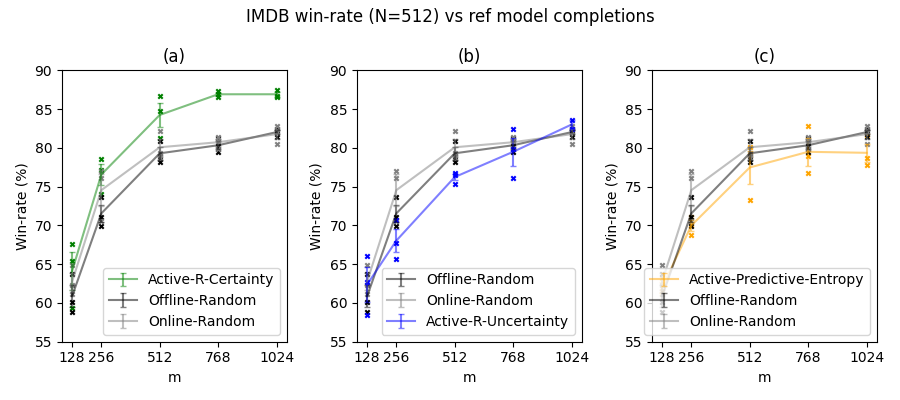

In [17]:
plot_winrate_grid(df, df_agg, [
    ["RANDOM", "OFFLINE", "CERTAINTY"], 
    ["RANDOM", "OFFLINE", "UNCERTAINTY"], 
    ["RANDOM", "OFFLINE", "ENTROPY"]], 
                  output_path="imdb-final-vs-refmodel.png", 
                  ncols=3, 
                  acq="acq",
                  figwidth=9,
                  title="IMDB win-rate (N=512) vs ref model completions")

In [18]:
agg_df = df.groupby(["acq", "m"])[WIN_RATE].agg(["count", "mean", "std"])

for BASELINE in ["RANDOM", "OFFLINE"]:

    def do_ttest(g):
        m = g["m"].iloc[0]
        bdf = df[(df["acq"] == BASELINE) & (df["m"] == m)]
        return stats.ttest_ind(g[WIN_RATE], bdf[WIN_RATE]).pvalue

    def diff_mean(g):
        m = g["m"].iloc[0]
        bdf = df[(df["acq"] == BASELINE) & (df["m"] == m)]
        return g[WIN_RATE].mean() - bdf[WIN_RATE].mean()

    def diff_mean_std(g):
        m = g["m"].iloc[0]
        bdf = df[(df["acq"] == BASELINE) & (df["m"] == m)]
        return (g[WIN_RATE].std()**2 + bdf[WIN_RATE].std()**2)**0.5

    agg_df[f"effect_vs_{BASELINE}"] = df.groupby(["acq", "m"]).apply(diff_mean)
    agg_df[f"std_effect_vs_{BASELINE}"] = df.groupby(["acq", "m"]).apply(diff_mean_std)
    agg_df[f"pvalue_vs_{BASELINE}"] = df.groupby(["acq", "m"]).apply(do_ttest)


agg_df

count      mean       std  effect_vs_RANDOM  \
acq         m                                                   
CERTAINTY   128       3  0.641276  0.042537          0.013672   
            256       3  0.765625  0.023027          0.020182   
            512       3  0.842448  0.027713          0.041667   
            768       3  0.869141  0.003906          0.061849   
            1024      3  0.869141  0.005167          0.051432   
ENTROPY     128       3  0.619792  0.011444         -0.007812   
            256       3  0.699870  0.011773         -0.045573   
            512       3  0.774740  0.036972         -0.026042   
            768       3  0.794922  0.030696         -0.012370   
            1024      3  0.793620  0.020329         -0.024089   
OFFLINE     128       3  0.608724  0.025190         -0.018880   
            256       3  0.715495  0.018970         -0.029948   
            512       3  0.792969  0.014084         -0.007812   
            768       3  0.803385  0.008807         -0.003906   
            1024      3  0.820312  0.005167          0.002604   
RANDOM      128       3  0.627604  0.018970          0.000000   
            256       3  0.745443  0.035174          0.000000   
            512       3  0.800781  0.018835          0.000000   
            768       3  0.807292  0.007893          0.000000   
            1024      3  0.817708  0.011934          0.000000   
UNCERTAINTY 128       3  0.623698  0.038190         -0.003906   
            256       3  0.680339  0.025491         -0.065104   
            512       3  0.762370  0.007394         -0.038411   
            768       3  0.794922  0.031433         -0.012370   
            1024      2  0.830078  0.008286          0.012370   

                  std_effect_vs_RANDOM  pvalue_vs_RANDOM  effect_vs_OFFLINE  \
acq         m                                                                 
CERTAINTY   128               0.046576          0.637911           0.032552   
            256               0.042041          0.452455           0.050130   
            512               0.033508          0.097568           0.049479   
            768               0.008807          0.000262           0.065755   
            1024              0.013005          0.002377           0.048828   
ENTROPY     128               0.022155          0.574345           0.011068   
            256               0.037092          0.100427          -0.015625   
            512               0.041493          0.338133          -0.018229   
            768               0.031694          0.536115          -0.008464   
            1024              0.023573          0.151448          -0.026693   
OFFLINE     128               0.031534          0.358293           0.000000   
            256               0.039964          0.264085           0.000000   
            512               0.023519          0.595867           0.000000   
            768               0.011827          0.597885           0.000000   
            1024              0.013005          0.746187           0.000000   
RANDOM      128               0.026827          1.000000           0.018880   
            256               0.049744          1.000000           0.029948   
            512               0.026637          1.000000           0.007812   
            768               0.011163          1.000000           0.003906   
            1024              0.016877          1.000000          -0.002604   
UNCERTAINTY 128               0.042642          0.881621           0.014974   
            256               0.043440          0.060310          -0.035156   
            512               0.020235          0.030274          -0.030599   
            768               0.032409          0.544688          -0.008464   
            1024              0.014529          0.300468           0.009766   

                  std_effect_vs_OFFLINE  pvalue_vs_OFFLINE  
acq         m                                               
CERTAI

In [19]:
print(agg_df.reset_index().to_latex(index=False, float_format="%.03f"))

\begin{tabular}{lrrrrrrrrrr}
\toprule
        acq &    m &  count &  mean &   std &  effect\_vs\_RANDOM &  std\_effect\_vs\_RANDOM &  pvalue\_vs\_RANDOM &  effect\_vs\_OFFLINE &  std\_effect\_vs\_OFFLINE &  pvalue\_vs\_OFFLINE \\
\midrule
  CERTAINTY &  128 &      3 & 0.641 & 0.043 &             0.014 &                 0.047 &             0.638 &              0.033 &                  0.049 &              0.318 \\
  CERTAINTY &  256 &      3 & 0.766 & 0.023 &             0.020 &                 0.042 &             0.452 &              0.050 &                  0.030 &              0.044 \\
  CERTAINTY &  512 &      3 & 0.842 & 0.028 &             0.042 &                 0.034 &             0.098 &              0.049 &                  0.031 &              0.051 \\
  CERTAINTY &  768 &      3 & 0.869 & 0.004 &             0.062 &                 0.009 &             0.000 &              0.066 &                  0.010 &              0.000 \\
  CERTAINTY & 1024 &      3 & 0.869 & 0.005 &    

In [20]:
print(agg_df[["effect_vs_OFFLINE", "std_effect_vs_OFFLINE", "effect_vs_RANDOM", "std_effect_vs_RANDOM"]].to_latex( float_format=lambda f: f"{f*100:.01f}"))

\begin{tabular}{llrrrr}
\toprule
            &      &  effect\_vs\_OFFLINE &  std\_effect\_vs\_OFFLINE &  effect\_vs\_RANDOM &  std\_effect\_vs\_RANDOM \\
acq & m &                    &                        &                   &                       \\
\midrule
CERTAINTY & 128  &                3.3 &                    4.9 &               1.4 &                   4.7 \\
            & 256  &                5.0 &                    3.0 &               2.0 &                   4.2 \\
            & 512  &                4.9 &                    3.1 &               4.2 &                   3.4 \\
            & 768  &                6.6 &                    1.0 &               6.2 &                   0.9 \\
            & 1024 &                4.9 &                    0.7 &               5.1 &                   1.3 \\
ENTROPY & 128  &                1.1 &                    2.8 &              -0.8 &                   2.2 \\
            & 256  &               -1.6 &                    2.2 &   